# Titanic Dataset

* The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

* Attribute Descriptions:
    * **PassengerId**: a unique identifier for each passenger
    * **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
    * **Pclass**: passenger class.
    * **Name**, **Sex**, **Age**: self-explanatory
    * **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
    * **Parch**: how many children & parents of the passenger aboard the Titanic.
    * **Ticket**: ticket id
    * **Fare**: price paid (in pounds)
    * **Cabin**: passenger's cabin number
    * **Embarked**: where the passenger embarked the Titanic

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

import eda_helper as eda

### Get the Data:

In [2]:
train_data = pd.read_csv('https://raw.githubusercontent.com/Spin8Cycle/data/main/data_samples/titanic/train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/Spin8Cycle/data/main/data_samples/titanic/test.csv')

### Explore the Data:

In [3]:
eda.custom_info(train_data)

,Data Type,Non-Null Count,Null Count,% Missing,Distinct Values
PassengerId,int64,891,0,0.0,891
Survived,int64,891,0,0.0,2
Pclass,int64,891,0,0.0,3
Name,object,891,0,0.0,891
Sex,object,891,0,0.0,2
Age,float64,714,177,19.87,88
SibSp,int64,891,0,0.0,7
Parch,int64,891,0,0.0,7
Ticket,object,891,0,0.0,681
Fare,float64,891,0,0.0,248


In [4]:
# Numerical Data
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Categorical Data?
train_data.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [6]:
def category_distribution(df, colnames):
    """
    Return the counts and distribution of the df's categorical values.

    Parameters
    ----------
    df : DataFrame
        Source DataFrame

    colnames : list
        List of column names, that represent categorical values

    Returns
    -------
    dist_df : DataFrame

    """
    try:
        data = []
        index_1 = []
        index_2 = []
        for n in colnames:
            vc = df[n].value_counts()
            vc2 = df[n].value_counts(normalize=True)
            for i in vc.index:
                index_1.append(n)
                index_2.append(i)
                data.append([vc[i], round(vc2[i] * 100, 2)])

        dist_df = pd.DataFrame(
            data, index=[index_1, index_2], columns=["Counts", "Distribution, %"]
        )

        return dist_df
    except:
        print("Please check if df or colnames is entered")

In [7]:
category_distribution(train_data, ['Sex', 'Survived', 'Embarked', 'Pclass'])

Counts  Distribution, %
Sex      male       577            64.76
         female     314            35.24
Survived 0          549            61.62
         1          342            38.38
Embarked S          644            72.44
         C          168            18.90
         Q           77             8.66
Pclass   3          491            55.11
         1          216            24.24
         2          184            20.65

C:\Users\JCA\AppData\Local\Temp\ipykernel_2900\1582602472.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_cor = train_data.drop(['PassengerId'], axis=1).corr()


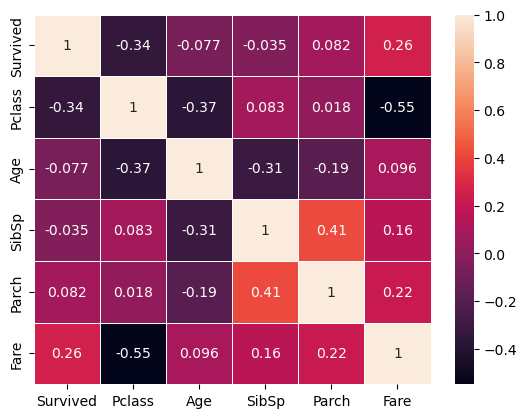

In [10]:
train_cor = train_data.drop(['PassengerId'], axis=1).corr()
sns.heatmap(train_cor, annot=True, linewidth=0.5);

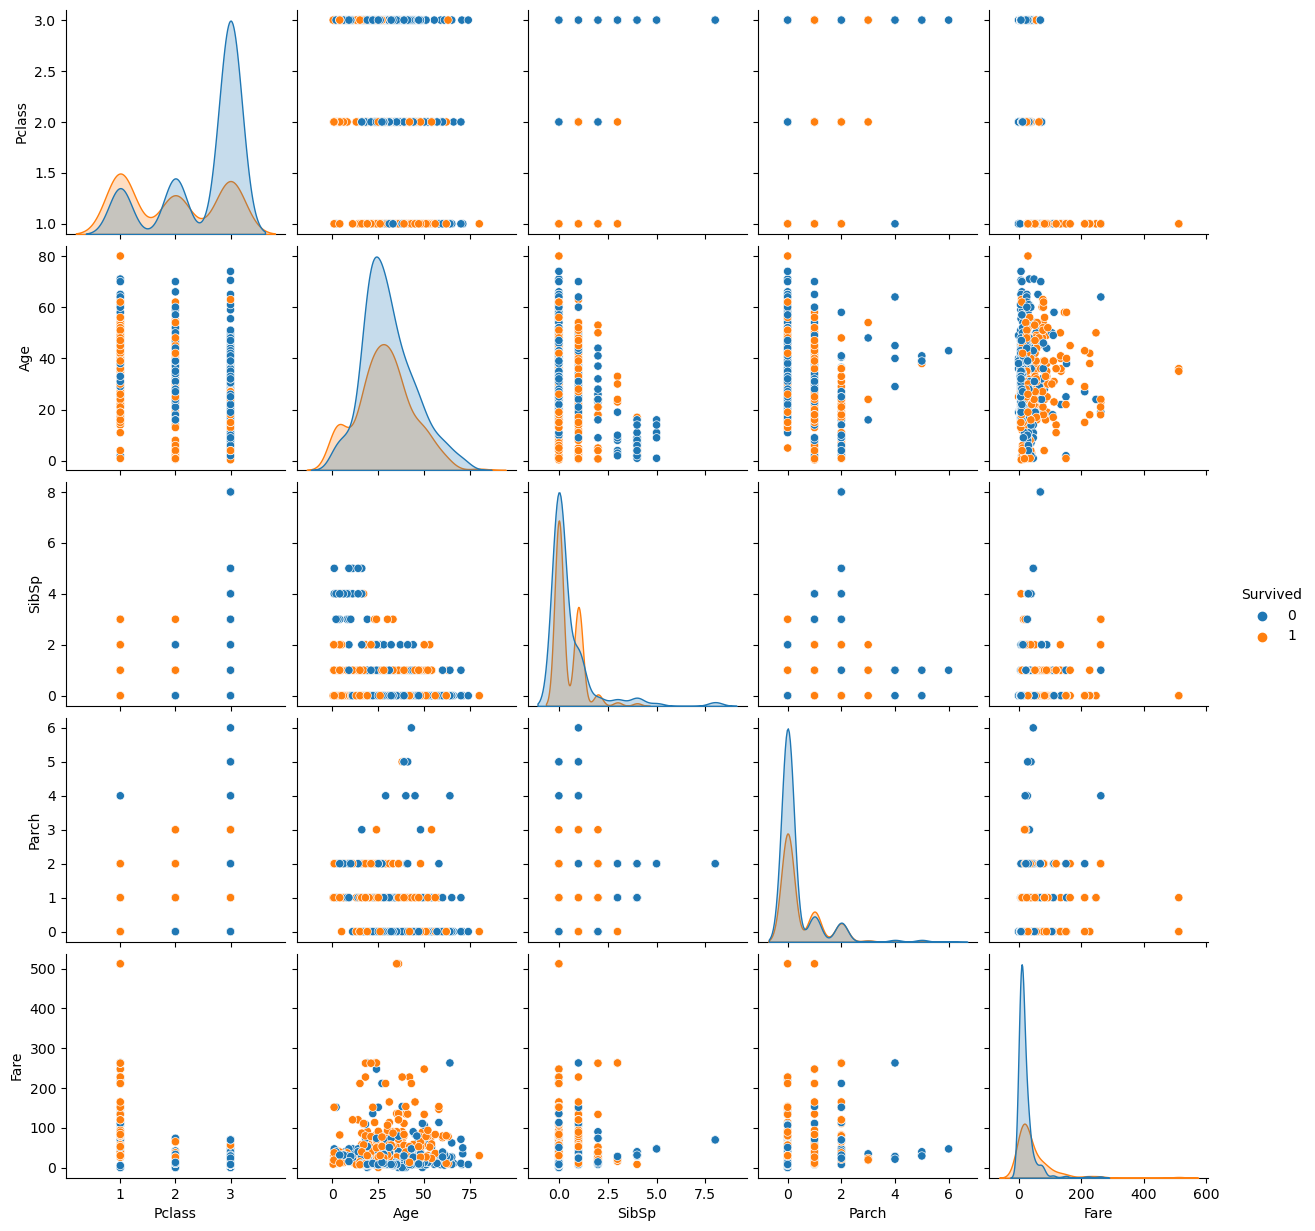

In [15]:
sns.pairplot(train_data.drop(['PassengerId', 'Name'], axis=1), hue='Survived')

### Prepare the Data:

In [16]:
# Combine SibSP and Parch
train_data['Relatives'] = train_data['SibSp'] + train_data['Parch']

# Create Age Bucket
train_data['AgeBucket'] = train_data['Age'] // 15 * 15

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [19]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse_output=False))
])

In [20]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Relatives', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked', 'AgeBucket']

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

preprocess_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Relatives', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('ordinal_encoder',
                                                  OrdinalEncoder()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['Pclass', 'Sex', 'Embarked', 'AgeBucket'])])

In [21]:
X_train = preprocess_pipeline.fit_transform(train_data)

In [22]:
y_train = train_data['Survived']

### Choose Model :

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [35]:
svm_clf = SVC()

svm_params ={
    'C':[0.1, 0.5, 1],
    'kernel': ['rbf', 'sigmoid'],
    'gamma':['scale', 'auto']
     }

svm_grid_search = GridSearchCV(
    svm_clf, param_grid=svm_params, cv=10, scoring='accuracy'
)

svm_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'sigmoid']},
             scoring='accuracy')

In [37]:
svm_grid_search.best_estimator_

SVC(C=1)

In [38]:
svm_grid_search.best_score_

0.832796504369538

In [43]:
svm_cv_results = pd.DataFrame(svm_grid_search.cv_results_)
svm_cv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
8,0.022110,0.003676,0.005699,0.001791,1,scale,rbf,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.811111,0.865169,...,0.898876,0.831461,0.808989,0.808989,0.808989,0.876404,0.853933,0.832797,0.038291,1
4,0.019410,0.001131,0.005101,0.000516,0.5,scale,rbf,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}",0.811111,0.865169,...,0.876404,0.820225,0.808989,0.820225,0.797753,0.865169,0.865169,0.829426,0.034986,2
10,0.018667,0.001266,0.005432,0.000952,1,auto,rbf,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.800000,0.842697,...,0.853933,0.820225,0.797753,0.820225,0.797753,0.853933,0.820225,0.818202,0.024851,3
6,0.028636,0.003226,0.008088,0.001807,0.5,auto,rbf,"{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}",0.788889,0.820225,...,0.842697,0.786517,0.786517,0.808989,0.797753,0.842697,0.797753,0.804732,0.022406,4
0,0.027760,0.005390,0.010525,0.005335,0.1,scale,rbf,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.800000,0.808989,...,0.831461,0.797753,0.775281,0.797753,0.797753,0.831461,0.797753,0.801348,0.018123,5
